## Fetal Immune Atlas - experimental design plots 


In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy

In [58]:
%load_ext rpy2.ipython

In [59]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [61]:
new_obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210428.full_obs.csv')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [92]:
df = new_obs[['uniform_label_lvl0', "uniform_label_expanded_merged","Sample", 'organ']].groupby(["uniform_label_lvl0","uniform_label_expanded_merged","organ"]).count() \
    .unstack(fill_value=0).stack().reset_index()
df.columns[2] 

'organ'

In [93]:
%%R -i df -w 1000 -h 1300
library(patchwork)

p1 <- df %>% 
rename(count=Sample) %>%
ggplot(aes(uniform_label_expanded_merged, count, fill=organ)) +
geom_col(position="fill") +
# scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
ylab("fraction") +
theme(strip.background = element_blank(),
  strip.text.y = element_blank()) 

p2 <- df %>%
rename(count=Sample) %>%
group_by(uniform_label_expanded_merged, uniform_label_lvl0) %>%
summarise(tot_count=sum(count)) %>%
ggplot(aes(uniform_label_expanded_merged, tot_count)) +
geom_col() +
scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
theme(strip.text.y=element_text(angle=0), axis.text.y=element_blank(),
     axis.ticks.y=element_blank(), axis.title.y=element_blank()) 

`summarise()` has grouped output by 'uniform_label_expanded_merged'. You can override using the `.groups` argument.


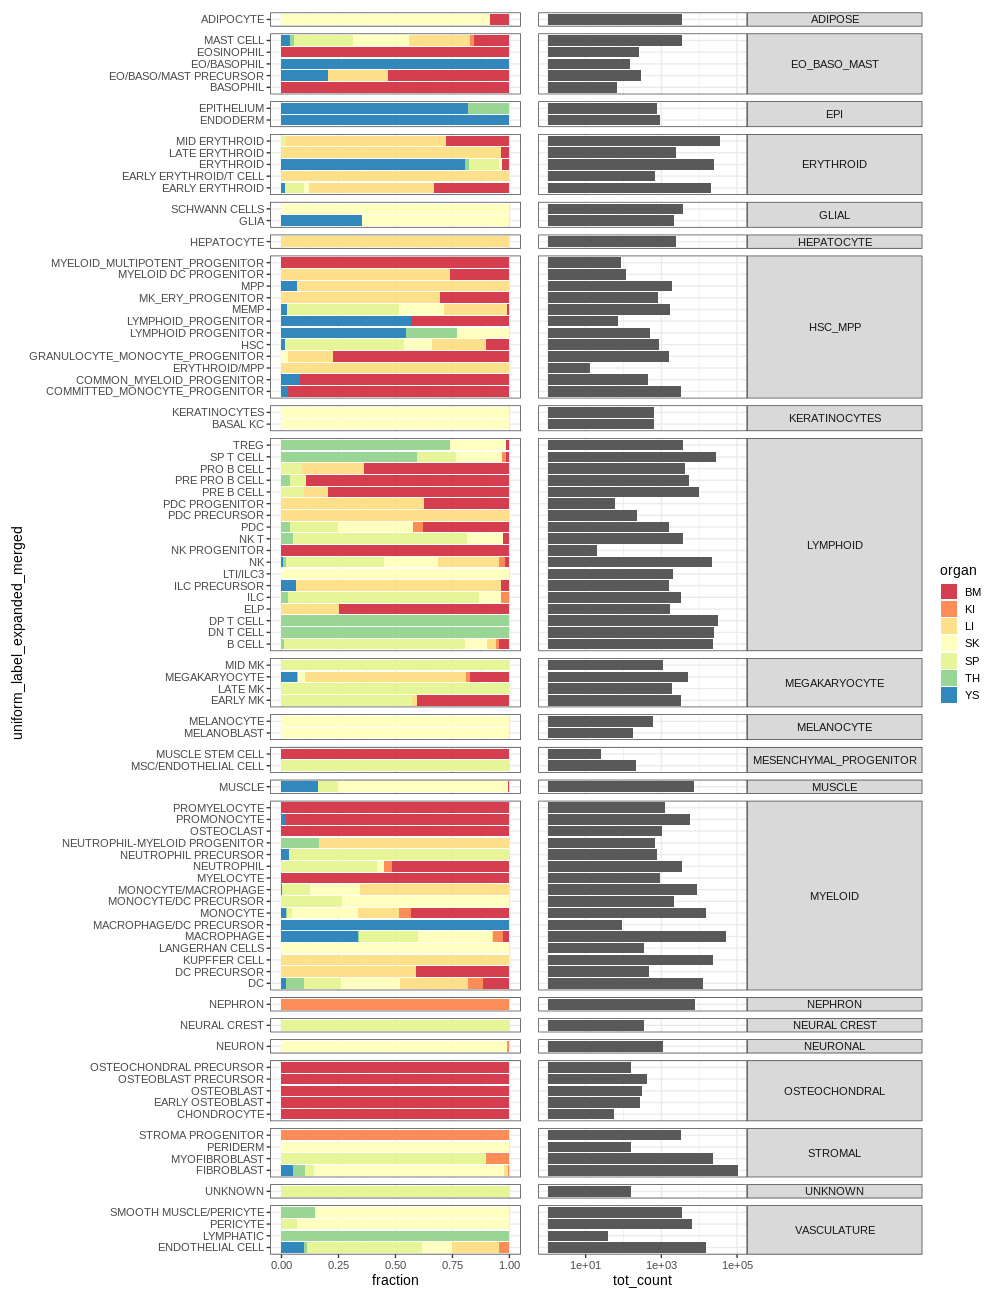

In [94]:
%%R -w 1000 -h 1300
p1 + p2 +
plot_layout(guides="collect", widths=c(1.2,1)) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.pdf", width=14, height=16) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.png", width=14, height=16)

In [95]:
donor_count = new_obs.reset_index()[["organ", "donor", "index"]].groupby(["donor", "organ"]).count().reset_index()


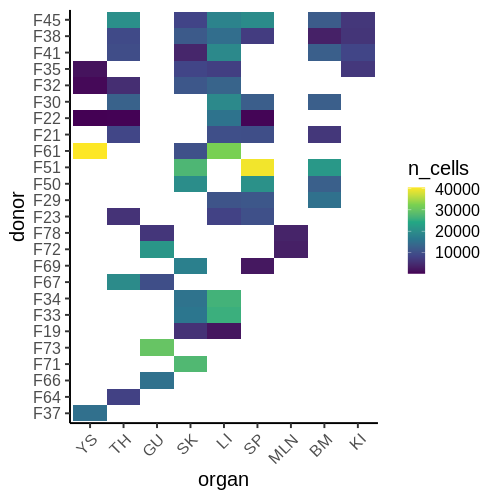

In [96]:
%%R -i donor_count -w 500 -h 500

donor_count %>%
rename(n_cells=index) %>%
mutate(organ=ifelse(organ=="TH(pharyn)", "TH", organ)) %>%
group_by(donor) %>%
mutate(n_organs=n()) %>%
ungroup() %>%
arrange(n_organs) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(organ, donor, fill=n_cells)) +
geom_tile() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1)) +
scale_fill_viridis_c() +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.pdf", width=7, height=8) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.png", width=7, height=8)

In [97]:
age_count = new_obs.reset_index()[["Sample", "organ", "donor", 'age',"index"]].groupby(["Sample", "donor", "organ", 'age']).count().reset_index()


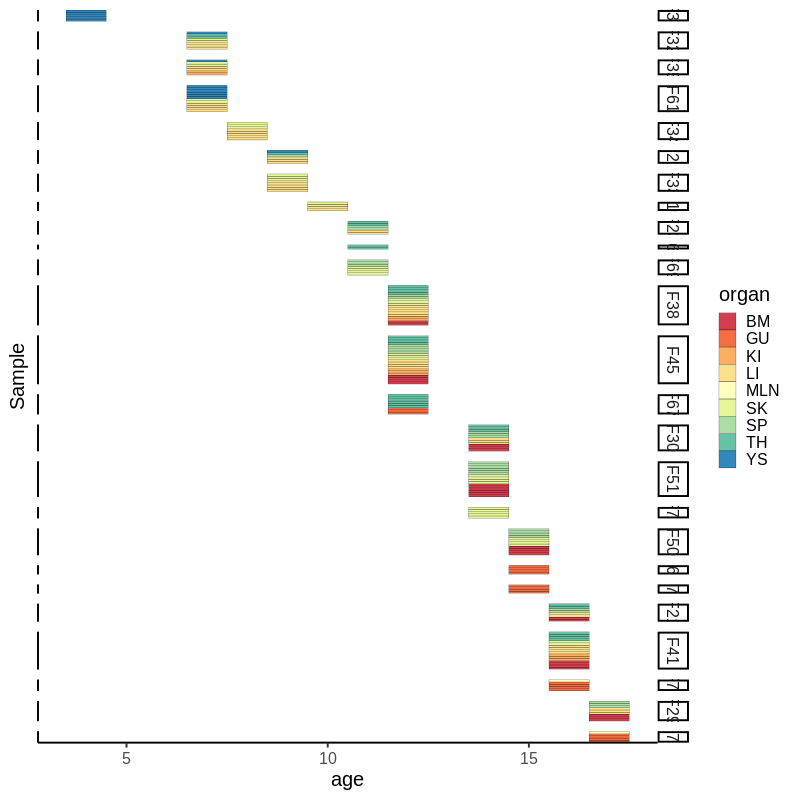

In [98]:
%%R -i age_count -w 800 -h 800

age_count %>%
rename(n_cells=index) %>%
arrange(age, donor, organ) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
# mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(age, Sample, fill=organ)) +
geom_tile(color='black') +
theme_classic(base_size=20) +
scale_fill_brewer(palette="Spectral") +
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
facet_grid(donor~., scales="free", space="free")


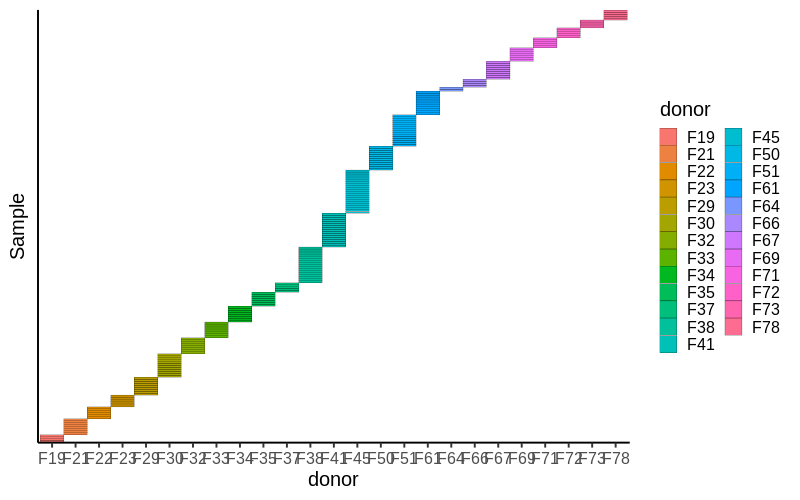

In [99]:
%%R -i age_count -w 800 -h 500

age_count %>%
rename(n_cells=index) %>%
arrange(donor, organ) %>%
# mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
# mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(donor, Sample, fill=donor)) +
geom_tile(color='black') +
theme_classic(base_size=20) +
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank())  
